In [32]:
import sys
import os
from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_repo_age_days_col, add_days_since_last_release_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, scale_final_data, remove_outliers, reduce_dimentionality_pca, forecast_growth, get_single_repo_data, remove_unwanted_features, distribute_features_across_releases, apply_time_based_noise, apply_proportional_noise, remove_first_augmented_rows
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)
from config import GITHUB_TOKEN



In [41]:
# https://github.com/tensorflow/tensorflow
# https://github.com/vim-airline/vim-airline
# https://github.com/numenta/nupic-legacy
# https://github.com/tensorflow/tensorflow
test_df = get_single_repo_data('https://github.com/numenta/nupic-legacy', GITHUB_TOKEN)

test_df.head(20)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,1.0.5,2018-06-01T15:12:12Z,30,464,2103,6335,1554,6335
1,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,1.0.4,2018-04-12T18:51:05Z,30,464,2103,6335,1554,6335
2,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,1.0.3,2017-09-13T18:24:07Z,30,464,2103,6335,1554,6335
3,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,1.0.2,2017-08-22T20:55:33Z,30,464,2103,6335,1554,6335
4,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,1.0.1,2017-08-08T20:01:55Z,30,464,2103,6335,1554,6335
5,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,1.0.0,2017-07-07T20:04:14Z,30,464,2103,6335,1554,6335
6,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,0.8.0,2017-06-08T20:31:16Z,30,464,2103,6335,1554,6335
7,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,0.7.0,2017-06-02T19:47:30Z,30,464,2103,6335,1554,6335
8,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,0.6.0,2017-03-30T18:10:12Z,30,464,2103,6335,1554,6335
9,numenta,nupic-legacy,Numenta Platform for Intelligent Computing is ...,https://github.com/numenta/nupic-legacy,"neocortex, artificial-intelligence, machine-in...",2013-04-05T23:14:27Z,2024-09-27T13:14:37Z,0.5.7,2016-11-28T23:01:58Z,30,464,2103,6335,1554,6335


In [42]:
if (test_df['num_releases'] <= 5).any():
    print('please provide a repos with more than 5 releases')


df_exploded = test_df 
df_exploded = df_exploded.sort_values(by='release_date', ascending=True).reset_index(drop=True)

df_augmented = distribute_features_across_releases(df_exploded, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues', 'num_releases'])
df_augmented = apply_time_based_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = apply_proportional_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = remove_first_augmented_rows(df_augmented)
df_augmented = add_growth_score_based_on_main_features(df_augmented, train=False)
actual_growth_score = df_augmented['growth_score']

test_df = df_augmented
test_df = add_repo_age_days_col(test_df)
test_df = add_days_since_last_release_col(test_df)
test_df = convert_topics_to_embeddings(test_df)
test_df = remove_outliers(test_df)
test_df = indexify_release_dates(test_df)

test_df = add_lag_features_based_on_target(test_df, num=5)

print(actual_growth_score)

/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['growth_score'] = scaled_features.sum(axis=1)
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['creation_date'] = pd.to_datetime(df['creation_date'])
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:165: SettingWithCopyWarn

0     0.033495
1     0.100347
2     0.162789
3     0.224239
4     0.280474
5     0.336940
6     0.391712
7     0.425994
8     0.464534
9     0.504053
10    0.538343
11    0.558163
12    0.581398
13    0.604266
14    0.655862
15    0.676070
16    0.701274
17    0.714401
18    0.738122
19    0.759160
20    0.794707
21    0.829666
22    0.862675
23    0.905286
24    0.952613
25    1.007693
26    1.061795
27    1.119011
28    1.184126
Name: growth_score, dtype: float64


/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_embedding'] = df['topics'].apply(lambda topic: sentence_embeddings_model.encode(topic))


In [43]:
X = remove_unwanted_features(test_df)
print(X.shape)
X_scaled = scale_final_data(X=X.values)
X_scaled_pca = reduce_dimentionality_pca(X_scaled)

# either/or
n_features_pca = X_scaled_pca.shape[1]
n_features = X_scaled.shape[1]

print(X_scaled_pca.shape[1], n_features_pca)
n_timesteps = 6
test_generator = TimeseriesGenerator(X_scaled_pca, np.zeros(len(X_scaled_pca)), length=n_timesteps, batch_size=1)
# test_generator = TimeseriesGenerator(X_scaled, np.zeros(len(X_scaled)), length=n_timesteps, batch_size=1)

model = load_model('../models/best_rnn_model.keras')

print(X_scaled_pca.shape[0])
print(model.summary())

y_pred = model.predict(test_generator)
print(f'predicted: {y_pred}', f' | actual: {actual_growth_score}')

(24, 397)
170 170
24


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6, 170)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 6, 64)     │     45,312 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 6, 64)     │          0 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 6, 64)     │          0 │ dropout_4[0][0],  │
│ (Attention)         │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 6, 64)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 6, 64)     │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64)        │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

None
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
predicted: [[1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356218]
 [1.7356225]]  | actual: 0     0.033495
1     0.100347
2     0.162789
3     0.224239
4     0.280474
5     0.336940
6     0.391712
7     0.425994
8     0.464534
9     0.504053
10    0.538343
11    0.558163
12    0.581398
13    0.604266
14    0.655862
15    0.676070
16    0.701274
17    0.714401
18    0.738122
19    0.759160
20    0.794707
21    0.829666
22    0.862675
23    0.905286
24    0.952613
25    1.007693
26    1.061795
27    1.119011
28    1.184126
Name: growth_score, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [44]:
# Use a few sample values from the actual data 
# just for sanity check to make sure the scaler is working correctly
sample_data = np.array([[0.3], [0.5], [0.7], [1.0], [1.2]])

scaler_y = joblib.load('../models/final_target_scaler.pkl')
scaled_data = scaler_y.transform(sample_data)
inverse_scaled_data = scaler_y.inverse_transform(scaled_data)

print("Original Data:\n", sample_data)
print("Scaled Data:\n", scaled_data)
print("Inverse Scaled Data:\n", inverse_scaled_data)

Original Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]
Scaled Data:
 [[0.28974655]
 [0.48291092]
 [0.67607529]
 [0.96582185]
 [1.15898621]]
Inverse Scaled Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]


In [45]:
n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')
print("Scaler data min:", scaler_y.data_min_)
print("Scaler data max:", scaler_y.data_max_)
print("Scaler feature range:", scaler_y.feature_range)


initial_data = X_scaled_pca[-n_timesteps:]
print(initial_data.shape)
print("Number of features in X_scaled_pca:", X_scaled_pca.shape[1])


# Perform the forecasting
forecasted_values = forecast_growth(
    model=model, 
    initial_data=initial_data, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=n_timesteps,
    n_features=n_features_pca
)

print("Forecasted Growth Scores:", forecasted_values)

Scaler data min: [0.]
Scaler data max: [1.03538764]
Scaler feature range: (0, 1)
(6, 170)
Number of features in X_scaled_pca: 170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecasted Growth Scores: [2.0134025 1.7999716 1.7999716 1.7999716 1.7999712 1.7999227 1.7970414
 1.7970414 1.7970414 1.7970414 1.7970414 1.7970414]


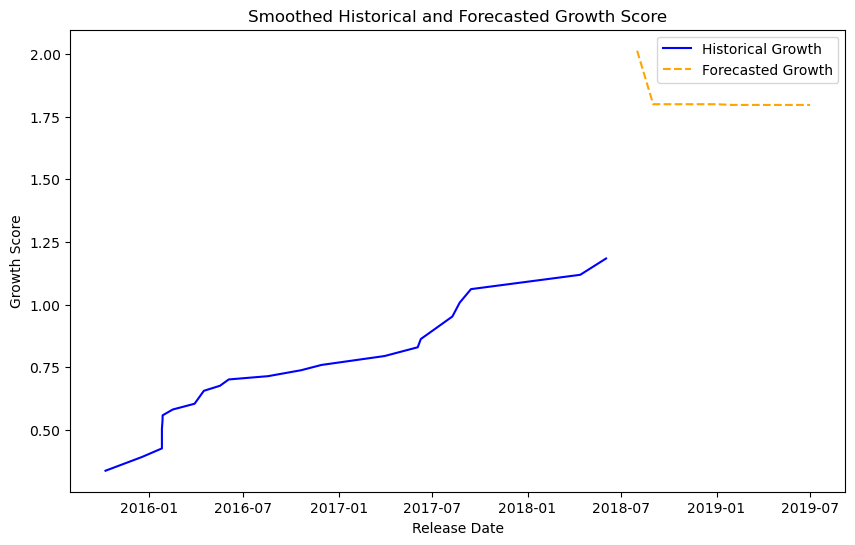

In [46]:
import pandas as pd
# Generate future dates for the forecasted values based on the release_date index by Monthly frequency
forecasted_dates = pd.date_range(start=test_df.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['growth_score'], color='blue', label='Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')


plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()

In [47]:
forecasted_values

array([2.0134025, 1.7999716, 1.7999716, 1.7999716, 1.7999712, 1.7999227,
       1.7970414, 1.7970414, 1.7970414, 1.7970414, 1.7970414, 1.7970414],
      dtype=float32)